In [13]:
import numpy as np
from torch.utils.data import Dataset
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import os
from tqdm import tqdm
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import torch
from datasets.gait import CasiaQueryDataset
from models.SpatialTransformerTemporalConv import SpatialTransformerTemporalConv, SpatioTemporalTransformer
from datasets.augmentation import *
from torchvision import transforms
from datasets.graph import Graph
from einops import rearrange
from einops.layers.torch import Rearrange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch
import torch.nn as nn
from pytorch_grad_cam import GradCAM
from evaluate import _evaluate_casia_b, evaluate, _evaluate_OUMVLP
from common import get_model_resgcn

In [14]:
dataset = CasiaQueryDataset(
#     '/home/epinyoan/git/deep-high-resolution-net.pytorch/output/simdr_pose_hrnet_w48_384x288_split1_5_sigma4/npy',
    '/home/epinyoan/git/GaitSelfFormer/v2_all/data/casiab_npy',
    id_range='75-124',
    duplicate_bgcl=False,
    transform=transforms.Compose([
        SelectSequenceCenter(60),
        remove_conf(enable=True),
        normalize_width,
        ToTensor()]))
data_target = {}
# subject_id, walking_status, sequence_num, view_angle
for data in dataset:
    data_target[tuple(data[1])] = data[0]
    
coco_bones = [
    [15, 13], [13, 11], [11, 5],
    [12, 14], [14, 16], [12, 6],
    [3, 1], [1, 2], [1, 0], [0, 2], [2, 4],
    [9, 7], [7, 5], [5, 6],
    [6, 8], [8, 10],
]

CasiaQueryDataset: 5375


In [15]:
val_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=8,
    pin_memory=True,
)

<IPython.core.display.Javascript object>


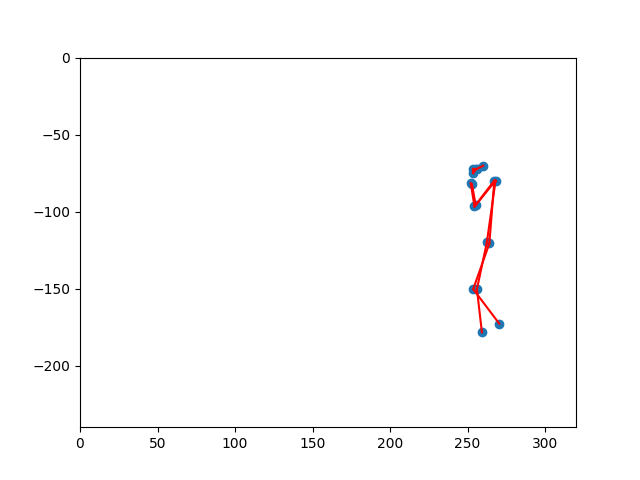

In [4]:
def display_animate(data, w=320, h=240):
    def animate(frame_num):
        ax.clear()
        x = data[frame_num,:,0]
        y = -data[frame_num,:,1]
        ax.set_xlim(0, w)
        ax.set_ylim(-h, 0)
        ax.scatter(x,y)
        for i, bone in enumerate(coco_bones):
            ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], 'r')
    fig, ax = plt.subplots()
    animate(0)
    return FuncAnimation(fig, animate, frames=data.shape[0], interval=20)
display_animate( (dataset[1][0]*320))

In [6]:
# 1. GaitGraph (rm 'remve_conf')
# checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-05-14-39-04_16_gaitgraph_lr6e-3/checkpoint/last.pth')
# model = get_model_resgcn()

# 2. GaitMixer
# checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-04-12-40-45_11_nolocal_32_64_128_256_lr6e-3/checkpoint/last.pth')
# model = SpatialTransformerTemporalConv(
#             num_frame=60, in_chans=2, spatial_embed_dim=32, out_dim=128, num_joints=17, kernel_frame=31)

# 3. SpatioTemporal Transformer
checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-11-23-08-08_26_spTempTransformer_lr6e-3/checkpoint/last.pth')
model = model = SpatioTemporalTransformer(
            num_frame=60, in_chans=2, spatial_embed_dim=32, out_dim=128, num_joints=17)

model.load_state_dict(checkpoint, strict=True)
model.cuda()

embeddings = evaluate(val_loader, model, lambda x:x, gpu=False)

Test: [0/21]	Time 1.016 (1.016)	
Test: [10/21]	Time 0.307 (0.373)	
Test: [20/21]	Time 0.307 (0.342)	


### Sort embedding by distance

In [6]:
correct_distance = []
incorrect_distance = []
def _evaluate_casia_b(embeddings):
    gallery = {k: v for (k, v) in embeddings.items()
               if k[1] == 0 and k[2] <= 4}
    gallery_per_angle = {}
    for angle in range(0, 181, 18):
        gallery_per_angle[angle] = {
            k: v for (k, v) in gallery.items() if k[3] == angle}

    probe_nm = {k: v for (k, v) in embeddings.items()
                if k[1] == 0 and k[2] >= 5}
    probe_bg = {k: v for (k, v) in embeddings.items() if k[1] == 1}
    probe_cl = {k: v for (k, v) in embeddings.items() if k[1] == 2}

    correct = np.zeros((3, 11, 11))
    total = np.zeros((3, 11, 11))
    for gallery_angle in range(0, 181, 18):
        gallery_embeddings = np.array(
            list(gallery_per_angle[gallery_angle].values()))
        gallery_targets = list(gallery_per_angle[gallery_angle].keys())
        gallery_pos = int(gallery_angle / 18)

        probe_num = 0
        for probe in [probe_nm, probe_bg, probe_cl]:
            for (target, embedding) in probe.items():
                subject_id, _, _, probe_angle = target
                probe_pos = int(probe_angle / 18)

                gallery_embeddings_norm = gallery_embeddings / \
                    np.linalg.norm(gallery_embeddings, ord=2,
                                   axis=1, keepdims=True)
                embedding_norm = embedding / \
                    np.linalg.norm(embedding, ord=2, keepdims=True)
                distance = 1 - gallery_embeddings_norm @ embedding_norm

                min_pos = np.argmin(distance)
                min_target = gallery_targets[int(min_pos)]

                if min_target[0] == subject_id:
                    if probe_angle != gallery_angle:
                        correct[probe_num, gallery_pos, probe_pos] += 1
                        correct_distance.append((min_pos, target, min_target))
                else:
                    if probe_angle == gallery_angle:
                        incorrect_distance.append((min_pos, target, min_target))
                total[probe_num, gallery_pos, probe_pos] += 1
_evaluate_casia_b(embeddings)

In [35]:
correct_distance = sorted(correct_distance, key=lambda x:x[0])
incorrect_distance = sorted(incorrect_distance, key=lambda x:x[0])
correct_distance

[(0, (100, 2, 2, 126), (100, 0, 1, 0)),
 (0, (100, 1, 1, 126), (100, 0, 1, 18)),
 (0, (100, 2, 1, 108), (100, 0, 1, 18)),
 (0, (100, 2, 1, 126), (100, 0, 1, 18)),
 (0, (100, 2, 1, 144), (100, 0, 1, 18)),
 (0, (100, 2, 1, 162), (100, 0, 1, 18)),
 (0, (100, 2, 1, 180), (100, 0, 1, 18)),
 (0, (100, 2, 2, 144), (100, 0, 1, 18)),
 (0, (100, 2, 2, 162), (100, 0, 1, 18)),
 (0, (100, 2, 2, 36), (100, 0, 1, 18)),
 (0, (100, 1, 1, 126), (100, 0, 1, 36)),
 (0, (100, 1, 1, 72), (100, 0, 1, 36)),
 (0, (100, 1, 1, 90), (100, 0, 1, 36)),
 (0, (100, 1, 2, 72), (100, 0, 1, 36)),
 (0, (100, 2, 1, 108), (100, 0, 1, 36)),
 (0, (100, 2, 1, 126), (100, 0, 1, 36)),
 (0, (100, 2, 1, 144), (100, 0, 1, 36)),
 (0, (100, 2, 1, 162), (100, 0, 1, 36)),
 (0, (100, 2, 2, 108), (100, 0, 1, 36)),
 (0, (100, 2, 2, 126), (100, 0, 1, 36)),
 (0, (100, 2, 2, 144), (100, 0, 1, 36)),
 (0, (100, 2, 2, 54), (100, 0, 1, 36)),
 (0, (100, 0, 5, 36), (100, 0, 1, 54)),
 (0, (100, 0, 6, 36), (100, 0, 1, 54)),
 (0, (100, 1, 2, 108), (

### Find incorrect GaitGraph but correct GaitMixer
- evalue on gaitmixer first then run gaitgraph again

In [52]:
gaitmixer_incorrect_distance = incorrect_distance
len(gaitmixer_incorrect_distance)

249

In [45]:
gaitgraph_incorrect_distance = incorrect_distance
len(gaitgraph_incorrect_distance)

440

In [58]:
gaitgraph_incorrect__gaitmixer_correct = []
for d, probe, gallery in gaitgraph_incorrect_distance:
    for d_mixer, probe_mixer, gallery_mixer in gaitmixer_incorrect_distance:
        if probe==probe_mixer and gallery_mixer:
            continue
    gaitgraph_incorrect__gaitmixer_correct.append((d, probe, gallery))
gaitgraph_incorrect__gaitmixer_correct

[(0, (102, 1, 1, 18), (100, 0, 1, 18)),
 (0, (102, 1, 1, 54), (100, 0, 1, 54)),
 (0, (102, 2, 1, 54), (100, 0, 1, 54)),
 (0, (110, 1, 1, 180), (100, 0, 1, 180)),
 (3, (102, 1, 1, 0), (100, 0, 4, 0)),
 (3, (110, 1, 1, 18), (100, 0, 4, 18)),
 (4, (108, 1, 1, 72), (101, 0, 1, 72)),
 (7, (102, 1, 2, 108), (101, 0, 4, 108)),
 (8, (100, 2, 2, 72), (102, 0, 1, 72)),
 (8, (118, 2, 2, 72), (102, 0, 1, 72)),
 (8, (100, 2, 2, 108), (102, 0, 1, 108)),
 (8, (100, 1, 1, 144), (102, 0, 1, 144)),
 (8, (100, 1, 2, 144), (102, 0, 1, 144)),
 (8, (100, 2, 1, 144), (102, 0, 1, 144)),
 (9, (118, 2, 1, 54), (102, 0, 2, 54)),
 (9, (118, 2, 2, 90), (102, 0, 2, 90)),
 (9, (118, 2, 2, 108), (102, 0, 2, 108)),
 (9, (118, 2, 1, 126), (102, 0, 2, 126)),
 (11, (118, 2, 2, 126), (102, 0, 4, 126)),
 (12, (120, 1, 1, 108), (103, 0, 1, 108)),
 (12, (78, 1, 1, 108), (103, 0, 1, 108)),
 (12, (120, 1, 1, 144), (103, 0, 1, 144)),
 (16, (102, 2, 1, 108), (104, 0, 1, 108)),
 (16, (97, 1, 1, 180), (104, 0, 1, 180)),
 (18, (116

### pytorch_grad_cam

In [9]:
# _targets = (80,2,2,144) # subject_id, walking_status, sequence_num, view_angle
# input_tensor = data_target[_targets]
# input_tensor.shape

def plot_activation_graph(data, activation, w=320, h=240):
    def skeleton_plot(frame_num):
        x = data[frame_num,:,0]
        y = -data[frame_num,:,1]
        a = (frame_num%10)/20
        for i, bone in enumerate(coco_bones):
            if frame_num%10==0 or frame_num==data.shape[0]-1:
                a = .3
                ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], '#aaaaaa', linewidth=1, alpha=a)
            a = np.maximum(activation[frame_num][bone[0]], activation[frame_num][bone[1]]) #*1.2
            a = np.clip(a, a_min=0, a_max=1)
            ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], 'y', alpha=a)
                
    def activation_plot(frame_num):
        x = data[frame_num,:,0]
        y = -data[frame_num,:,1]
        for i in range(len(x)):
            ax.scatter(x[i],y[i], c='y', alpha=activation[frame_num][i])
        
    fig, ax = plt.subplots()
    ax.set_xlim(0, w)
    ax.set_ylim(-h, 0)
    ax.set_facecolor('black')
    for i in range(data.shape[0]):
        skeleton_plot(i)
    for i in range(data.shape[0]):
        activation_plot(i)
# plot_activation_graph(input_tensor*320, grayscale_cam)

In [10]:
def grad_cam_graph(target, plot=True, reshape_transform=lambda x:x):
    input_tensor = data_target[target].unsqueeze(dim=0)
    input_tensor = rearrange(input_tensor, 'b f j d -> b d f j')
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True, reshape_transform=reshape_transform)
    targets = [ClassifierOutputTarget(124)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    if plot:
        plot_activation_graph(data_target[target]*320, grayscale_cam)
    return grayscale_cam

In [11]:
def plot_gradcam(data):
    y_axis = ["nose","left_eye","right_eye","left_ear","right_ear","left_shoulder","right_shoulder","left_elbow","right_elbow","left_wrist","right_wrist","left_hip","right_hip","left_knee","right_knee","left_ankle","right_ankle"]
    fig, ax = plt.subplots(1,1)
    plt.yticks(fontsize=6)
    ax.set_yticks(np.arange(len(y_axis)))
    ax.set_yticklabels(y_axis)
    ax.imshow(data)

### GaitMixer

<IPython.core.display.Javascript object>


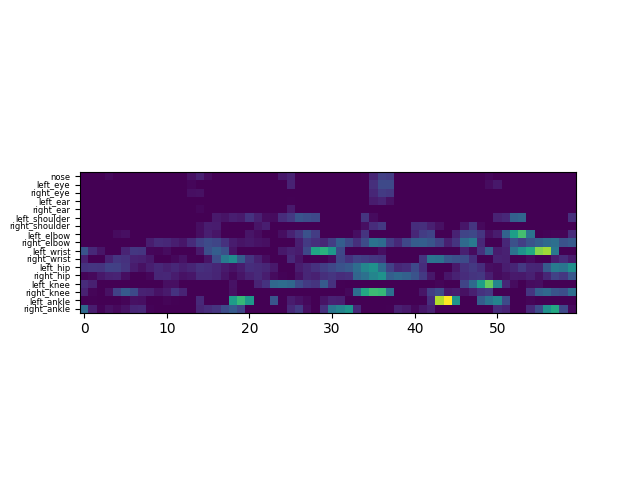

In [15]:
checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-04-12-40-45_11_nolocal_32_64_128_256_lr6e-3/checkpoint/last.pth')
# checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-04-13-50-45_12_globallocal_32_64_128_256_lr6e-3/checkpoint/last.pth')
# checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-11-15-30-34_25_no_l2norm_lr6e-3/checkpoint/last.pth')
model = SpatialTransformerTemporalConv(
            num_frame=60, in_chans=2, spatial_embed_dim=32, out_dim=128, num_joints=17, kernel_frame=31)
target_layers = [model.conv4]

model.load_state_dict(checkpoint, strict=True)
model = nn.Sequential(Rearrange('b d f j -> b f j d'), model)

# (191, (75, 2, 2, 18), (98, 0, 2, 18)),
grayscale_cam = grad_cam_graph((89, 2, 2, 36), plot=False)
# plt.imshow(grayscale_cam.T)
plot_gradcam(grayscale_cam.T)

<IPython.core.display.Javascript object>


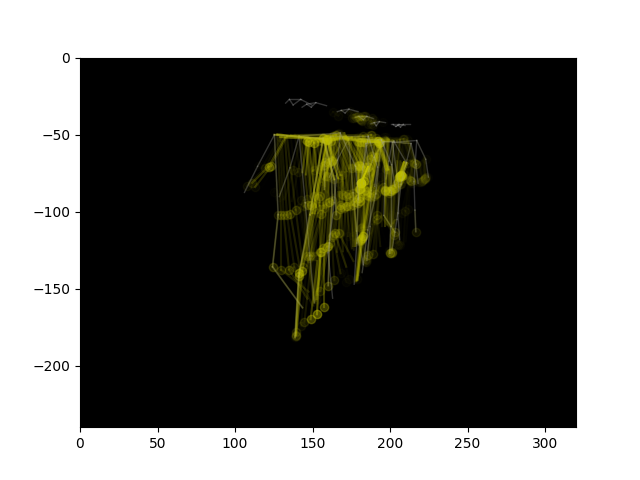

In [46]:
target = (98, 0, 2, 18) # subject_id, walking_status, sequence_num, view_angle
grayscale_cam = grad_cam_graph(target)

### SpatioTemporalTransformer

In [16]:
model = model = SpatioTemporalTransformer(
            num_frame=60, in_chans=2, spatial_embed_dim=32, out_dim=128, num_joints=17)
model.temporal_blocks[3]

Block(
  (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=32, out_features=96, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=32, out_features=32, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
  (norm2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (act): GELU()
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
)

output: torch.Size([17, 61, 32])
output: torch.Size([17, 61, 32])


<IPython.core.display.Javascript object>


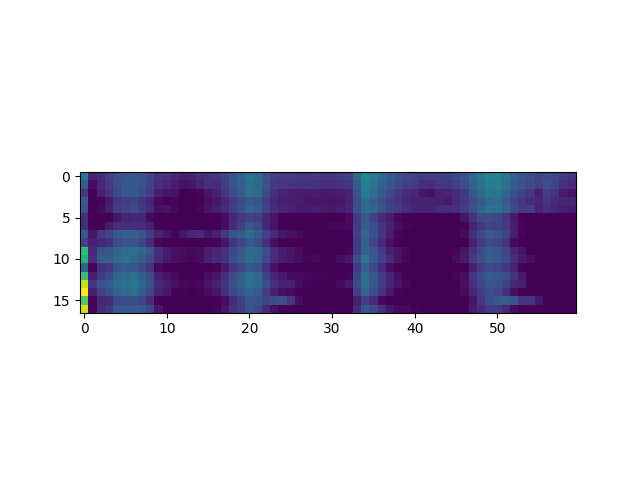

In [31]:
checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-11-23-08-08_26_spTempTransformer_lr6e-3/checkpoint/last.pth')
model = model = SpatioTemporalTransformer(
            num_frame=60, in_chans=2, spatial_embed_dim=32, out_dim=128, num_joints=17)
target_layers = [model.temporal_blocks[1]]

model.load_state_dict(checkpoint, strict=True)
model = nn.Sequential(Rearrange('b d f j -> b f j d'), model)

# (0, (100, 2, 2, 126), (100, 0, 1, 0))
def reshape_transform(output):
#         output = output[:,1:] # doesn't work bc cls is needed for training classifier
        print('output:', output.shape)
        output = output.permute((2,1,0)).unsqueeze(dim=0)
        return output
grayscale_cam = grad_cam_graph((109, 0, 1, 0), plot=False, reshape_transform=reshape_transform)
plt.imshow(grayscale_cam.T)

<IPython.core.display.Javascript object>


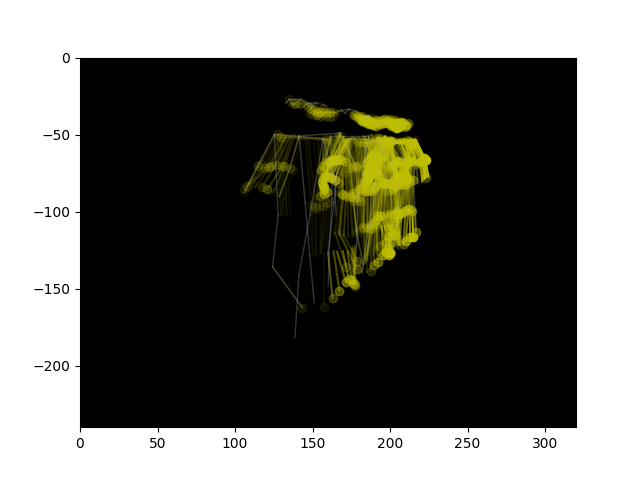

In [49]:
target = (98, 0, 2, 18) # subject_id, walking_status, sequence_num, view_angle
grayscale_cam = grad_cam_graph(target, reshape_transform=reshape_transform)

### GaitGraph
**** rm - remove_conf

<IPython.core.display.Javascript object>


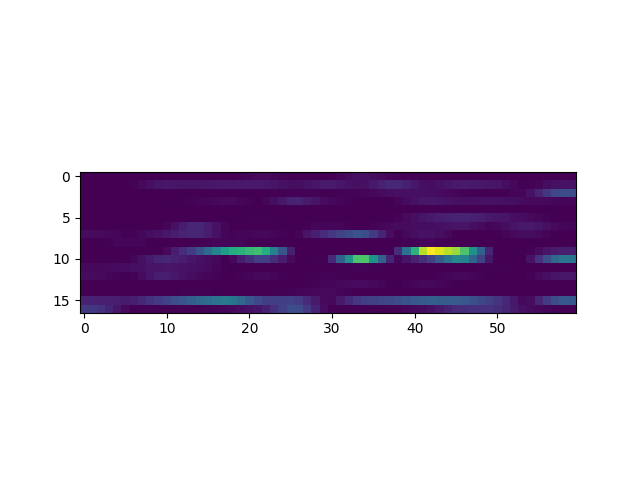

In [85]:
checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-05-14-39-04_16_gaitgraph_lr6e-3/checkpoint/last.pth')
model = get_model_resgcn()
model.load_state_dict(checkpoint, strict=True)
model = nn.Sequential(*[Rearrange('b d f j -> b f j d'), *[m for m in model]])
target_layers = [model[2].main_stream[3].tcn]

#(99, 1, 2, 72), (99, 0, 2, 54))
target = (98, 0, 2, 18)
grayscale_cam = grad_cam_graph(target, plot=False)
plt.imshow(grayscale_cam.T)

<IPython.core.display.Javascript object>


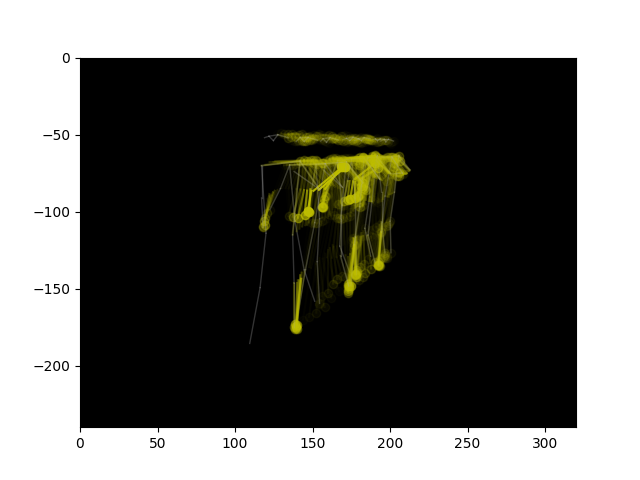

In [79]:
target = (102, 1, 1, 18)
grayscale_cam = grad_cam_graph(target)

### --------------

### Fourier Plot
https://github.com/ziplab/LITv2/issues/3 <Br>
https://mail.google.com/mail/u/1/#inbox/KtbxLthdmwmmwTsDJGRPmVwgFsQhQsWSQq

torch.Size([8, 60, 17])


<IPython.core.display.Javascript object>


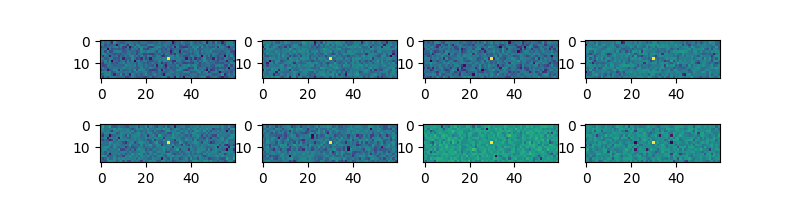

In [4]:
def plot_fft(data, avg=False):
    if avg:
        data = data.mean(dim=1, keepdim=True)
    # data (b,e,w,h)
    
    data = data.mean(dim=0).cpu()
    
    print(data.shape)
    
    # 1. FFT along temporal
#     fft_data = []
#     for i in range(data.shape[2]):
#         _data = data[:,:,i:i+1]
#         _data = torch.fft.fft2(_data.float())
#         _data = torch.log(torch.abs(torch.fft.fftshift(_data)))
#         fft_data.append(_data)
#     freq_img = torch.concat(fft_data, axis=2)
#     freq_img = torch.transpose(freq_img, 1,2)

    # 2. FFT along spatial
#     fft_data = []
#     for i in range(data.shape[1]):
#         _data = data[:,i:i+1,:]
#         _data = torch.fft.fft2(_data.float())
#         _data = torch.log(torch.abs(torch.fft.fftshift(_data)))
#         fft_data.append(_data)
#     freq_img = torch.concat(fft_data, axis=1)
    
    # 3. All spatial-temporal
    fft_input = torch.fft.fft2(data.float())
    freq_img = torch.log(torch.abs(torch.fft.fftshift(fft_input)))
    
#     print(freq_img.shape)
    num_plots = freq_img.shape[0]
    
    if avg:
        
#         plt.imshow(freq_img[0].detach().numpy().T)
        y_axis = ["nose","left_eye","right_eye","left_ear","right_ear","left_shoulder","right_shoulder","left_elbow","right_elbow","left_wrist","right_wrist","left_hip","right_hip","left_knee","right_knee","left_ankle","right_ankle"]
        fig, ax = plt.subplots(1,1)
        ax.axis('off')
        ax.imshow(freq_img[0].detach().numpy().T)
    else:
        num_per_row = 4
        fig, axis = plt.subplots(int(num_plots/num_per_row), num_per_row, figsize=(8 , num_plots/4)) #(4 , num_plots/2)
        for idx in range(num_plots):
            i = int(idx/num_per_row)
            j = int(idx%num_per_row)
            axis[i][j].imshow(freq_img[idx, ...].detach().numpy().T) #.repeat((1,17))
data = torch.rand((1,8,60,17))
plot_fft(data, avg=False)

forward_hook_fn: torch.Size([1, 32, 60, 17])
torch.Size([32, 60, 17])


<IPython.core.display.Javascript object>


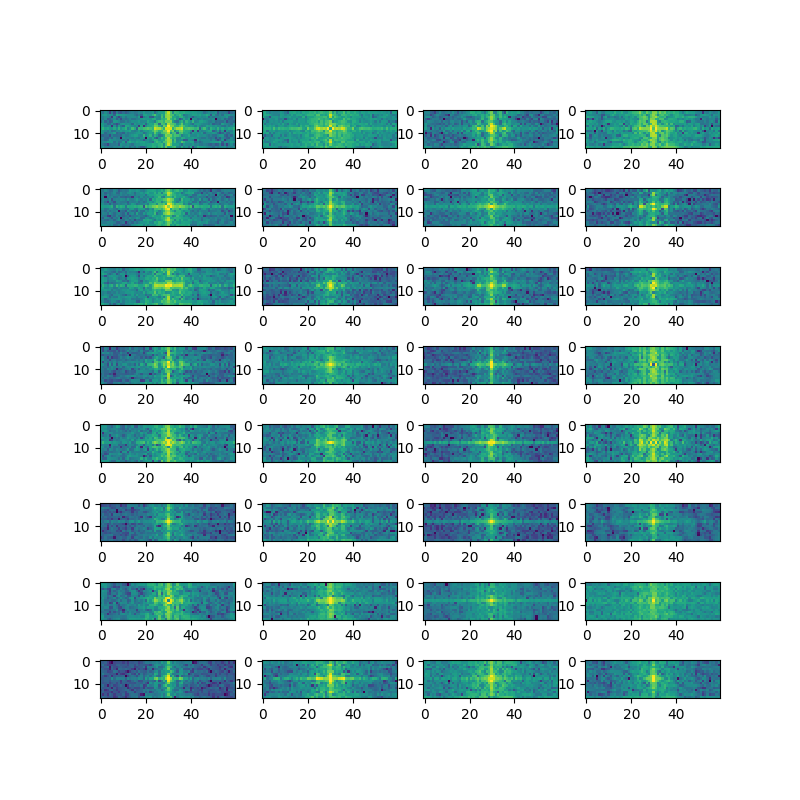

''

In [20]:
def forward_hook_fn(module, input, output):
    print('forward_hook_fn:', output.shape)
#     output = output[:, :, :, 15:16]
    plot_fft(output, avg=False)
def forward_transformer_hook_fn(module, input, output):
    output = output.permute((2,1,0))
    output = output[:,1:,:].unsqueeze(dim=0)
    print('forward_hook_fn:', output.shape)
    plot_fft(output, avg=False)

# 1. GaitMixer
# checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-04-12-40-45_11_nolocal_32_64_128_256_lr6e-3/checkpoint/last.pth')
# model = SpatialTransformerTemporalConv(
#             num_frame=60, in_chans=2, spatial_embed_dim=32, out_dim=128, num_joints=17, kernel_frame=31)
# model.conv4.act.register_forward_hook(forward_hook_fn)

# 2. GaitGraph (rm 'remove_conf()')
# checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-05-14-39-04_16_gaitgraph_lr6e-3/checkpoint/last.pth')
# model = get_model_resgcn()
# model[1].main_stream[3].tcn.register_forward_hook(forward_hook_fn)

# 3. Spatial Temporal Transformer
checkpoint = torch.load('/home/epinyoan/git/GaitSelfFormer/v2_all/save/unify/ablation_study/2022-10-11-23-08-08_26_spTempTransformer_lr6e-3/checkpoint/last.pth')
model = model = SpatioTemporalTransformer(
            num_frame=60, in_chans=2, spatial_embed_dim=32, out_dim=128, num_joints=17)
model.temporal_blocks[3].register_forward_hook(forward_transformer_hook_fn)



model.load_state_dict(checkpoint, strict=True)
data = dataset[0][0].unsqueeze(dim=0)
model(data)
''